## **Image Classification using VGG-16**

### <ins>1. Imports and Set-up</ins>


##### **1.1. Import Required Libraries**

In [327]:
import os
import random
import cv2
from tqdm import tqdm
import imutils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

##### **1.2. Set-up Static Seed, Image Directories and Show Snippets of Brain MRI Images**

['glioma', 'meningioma', 'notumor', 'pituitary']


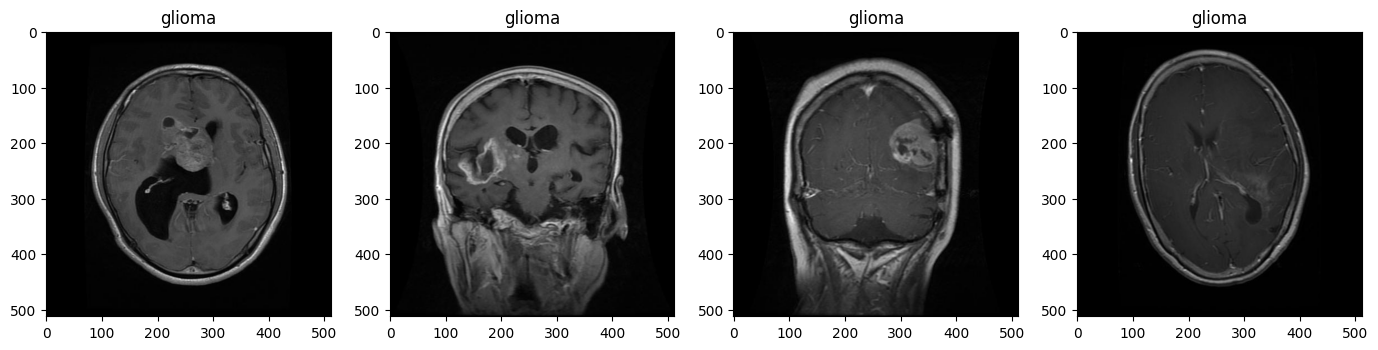

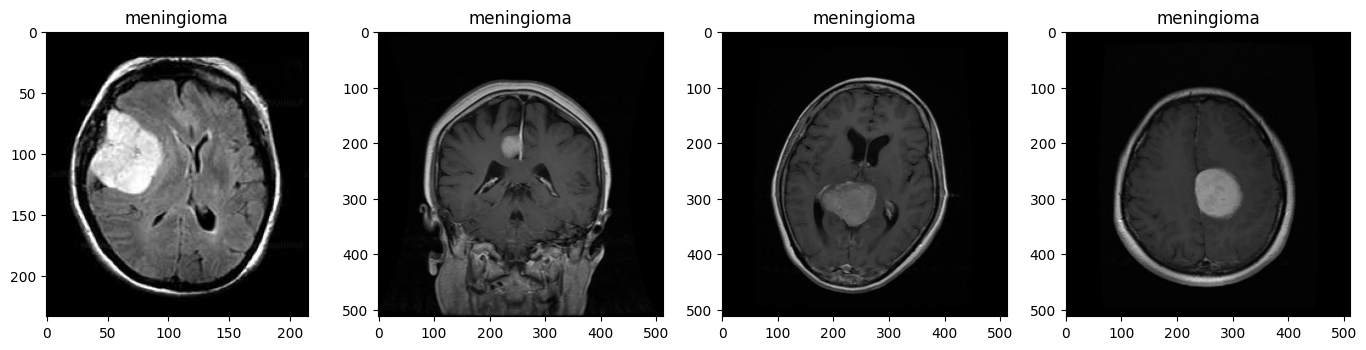

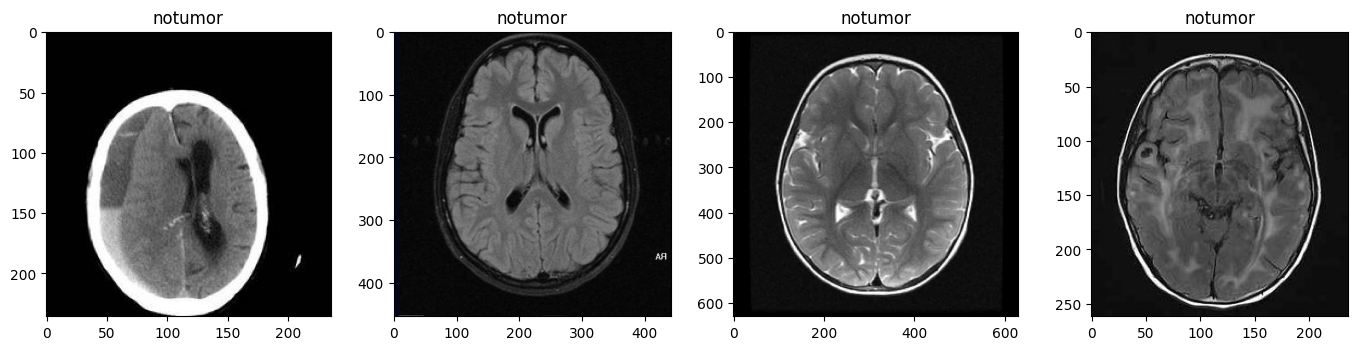

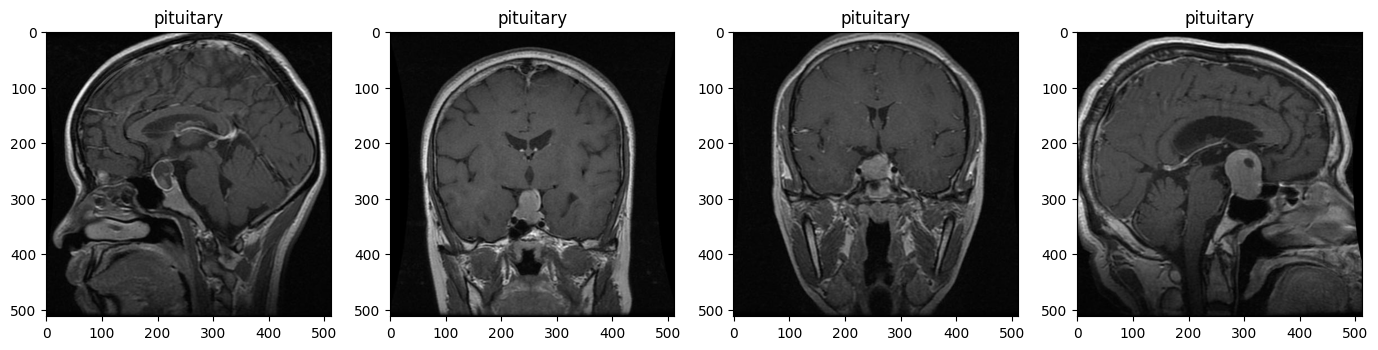

In [314]:
# Constant
SEED = 2203322

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)

# Set up directory paths
base_dir = '../../dataset_26'
data_dir = './preprocessed_data/train_validation_data'
unprocessed_test_dir = './unprocessed_test'
test_dir = './preprocessed_data/test_data'

# Create data directory for later preprocessed images
classes = os.listdir(base_dir)
os.makedirs(data_dir, exist_ok=True)
for cls in classes:
  os.makedirs(f'{data_dir}/{cls}', exist_ok=True)

# Print class labels
print(classes)

# Show snippet of brain MRI images
base_image_paths = {cls: list(map(lambda x: os.path.join(base_dir, cls, x), os.listdir(os.path.join(base_dir, cls)))) for cls in classes}
base_image_paths

for cls in classes:
  plt.figure(figsize=(17, 17))
  random.shuffle(base_image_paths[cls])
  files = base_image_paths[cls][:5]

  for i in range(1, 5):
    plt.subplot(4, 4, i)
    plt.imshow(load_img(files[i]))
    plt.title(cls)

### <ins>2. Data Preprocessing and Preparation</ins>

Preprocessing is done mainly via the `crop_image` function. The main purpose of it is to **crop/augment** the images to **exclude unimportant details** like the blank area around the actual scan of the head. Images passed through the function are essentially copied and manipulated to **find contours** so that we can **segregate important and unimportant details** from the original image.

It is done by first, performing **greyscaling** on the image. A **gaussian blur** is added to reduce noise and smoothen the image to aid in contour detection. We then perform **thresholding** to convert it to a binary image, where pixels above 45 are set to white (255) while pixels below 45 are set to black (0). Next, **erosion and dilation** are done to remove small noises and gaps in the image. We then **find all the contours** in the image and **select the largest contour** (corresponds to the actual scan of the head).

The original image is cropped using the largest contour data. Displaying the cropped image in a plot is an optional choice.

In [315]:
def crop_image(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]      

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

This `crop_img_saver` function takes the paths of the classes, reads each image and sends them to the `crop_image` function above. The cropped image is then resized to 224x224 pixels and saved in the specified directory.

In [316]:
def crop_img_saver(class_read_paths, save_dir):
  for cls in class_read_paths:
    for i, p in tqdm(enumerate(os.listdir(cls))):
      path = os.path.join(cls, p)
      img = crop_image(cv2.imread(path), plot=False)

      if img is not None:
        img = cv2.resize(img, (224, 224))
        save_class = cls.split('\\')[-1]
        save_path = os.path.join(save_dir, save_class, f'{str(i)}.jpg')
        cv2.imwrite(save_path, img)

Below, we make use of the functions to crop the images and save them in folders. You can see that 2 datasets are used, `base_dir` and `unprocessed_test_dir`. The directory `base_dir` contains the dataset provided to us.

The data in `unprocessed_test_dir` comes from an external source, namely the `Testing` folder data in https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data.

A separate python script (`sample_test_data.ipynb`) was used to extract another 480 total images from the folder, 120 images from each of the classifications. Filtering was done to ensure none of the 480 images were duplicates of the current data provided. This data is used purely for testing the model.

In [317]:
base_class_paths = [os.path.join(base_dir, cls) for cls in classes]
crop_img_saver(base_class_paths, save_dir=data_dir)


# Create test data directory for preprocessed test images
for cls in classes:
  os.makedirs(f'{test_dir}/{cls}', exist_ok=True)

# Crop test images
unprocessed_test_class_paths = [os.path.join(unprocessed_test_dir, cls) for cls in classes]
crop_img_saver(unprocessed_test_class_paths, save_dir=test_dir)

120it [00:00, 327.66it/s]
120it [00:00, 348.62it/s]
120it [00:00, 310.89it/s]
120it [00:00, 144.75it/s]
120it [00:00, 157.27it/s]
120it [00:01, 97.33it/s]
120it [00:01, 107.84it/s]
120it [00:00, 350.18it/s]


We use `ImageDataGenerator` to easily normalize and add further augmentations to the images (rotate, flip, etc.) without altering the original cropped images done above, as well as define a split of 20% for validation. We then use `flow_from_directory` to create generator objects for training and validation splits that fetch the images in batches (size specified by batch_size) in the form of tuples, and resize the images to 224x224 pixels.

We then show snippets of the cropped images.

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.


c:\Users\Frederick Ang\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


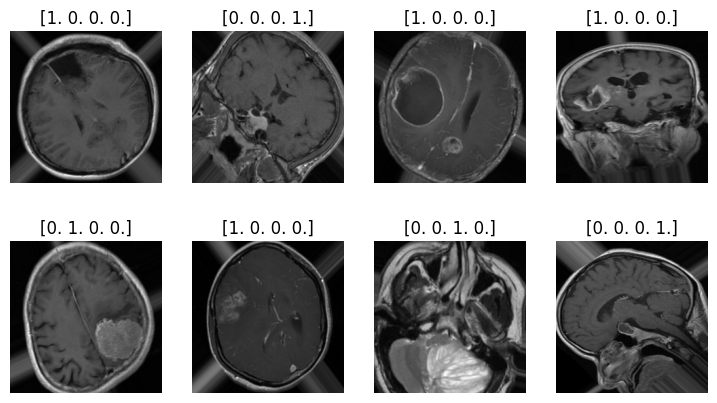

In [318]:
train_data_generator = ImageDataGenerator(rescale=1./255,
                                          rotation_range=45, 
                                          shear_range=0.2,
                                          zoom_range=0.2, 
                                          horizontal_flip=True,
                                          validation_split=0.2)

train_data = train_data_generator.flow_from_directory(data_dir,
                                                      target_size=(224, 224),
                                                      batch_size=16,
                                                      class_mode='categorical',
                                                      subset='training',
                                                      seed=SEED)

validation_data = train_data_generator.flow_from_directory(data_dir,
                                                      target_size=(224, 224),
                                                      batch_size=24,
                                                      class_mode='categorical',
                                                      subset='validation',
                                                      seed=SEED)

sample_x, sample_y = next(train_data)
plt.figure(figsize=(9, 5))
for i in range(8):
  plt.subplot(2, 4, i+1)
  plt.axis('off'), plt.grid(False)
  # sample_img = array_to_img(sample_x[i])
  plt.imshow(array_to_img(sample_x[i]))
  plt.title(sample_y[i])

### <ins>3. Model Training</ins>
##### **3.1. Load VGG-16 and Build Fully Connected Layers**
Firstly, we **load the VGG-16 model** which accepts inputs with the **shape of 224x224 pixels and 3 color channels (RGB)**. We **exclude the classification/fully connected layers** at the top of the network as they are designed for ImageNet classification tasks. Our goal is to classify brain tumors, so we need to add our own custom layers. By utilizing the base layers of VGG-16, we leverage **powerful feature extractors** that are **trained on a large and diverse dataset**. This allows us to perform **transfer learning** effectively. 

By **freezing the base layers**, we ensure that their learned representations of image features such as **edges, textures, and shapes are preserved**. This approach allows us to efficiently train the added custom classification/fully connected layers, which are designed to classify brain MRI images into specific tumor types with high accuracy.

The custom classification/fully connected layers are designed to reduce the risk of overfitting, especially given the small dataset provided. If `include_top` was **True**, it would only include **Flatten** and **Dense** layers. By including additional layers such as **BatchNormalization, Dropout,** and **Dense** layers with **different numbers of units and specific activation functions**, we tailor the model to our specific task and improve its generalization capabilities.

In [319]:
# Load the VGG16 model without the classification/fully connected layers
vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base layers of the model
for layer in vgg16_base.layers:
    layer.trainable = False

# Layers
model = Sequential()
model.add(vgg16_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))  # 4 classes for classification


##### **3.2. Set-Up Optimizing Callbacks**
To enhance the model training process, we use several callbacks that provide functionality such as early stopping, checkpoint saving, and learning rate reduction. These callbacks help in optimizing the training process by preventing overfitting, saving the best model, and adjusting the learning rate dynamically.

In [320]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='auto',
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model_ckpt.model.keras', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='auto',
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=2, 
    min_lr=0.000001,
    verbose=1
)

##### **3.3. Compile and Train Model**
The model is compiled with the **Adam optimizer** at a learning rate of **0.0001** and uses **categorical_crossentropy** for the loss function, which is suitable for multi-class classification. We set the metric as accuracy to gauge model improvements during training.

The model is then set to be trained for **20 epochs**, implementing the callbacks initialized above.

In [321]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_data,
    validation_data=validation_data,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    epochs=20
)

model.summary()

Epoch 1/20


c:\Users\Frederick Ang\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3618 - loss: 1.9925
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to model_ckpt.model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3654 - loss: 1.9773 - val_accuracy: 0.5000 - val_loss: 1.1023 - learning_rate: 1.0000e-04
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6591 - loss: 0.9461
Epoch 2: val_accuracy improved from 0.50000 to 0.52083, saving model to model_ckpt.model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6578 - loss: 0.9474 - val_accuracy: 0.5208 - val_loss: 1.0122 - learning_rate: 1.0000e-04
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6442 - loss: 0.9963
Epoch 3: val_accuracy improved from 0.52083 to 0.58333, saving model to model_ckpt.model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6458 - loss: 0.9909 - val_accuracy: 0.5833 - val_loss: 0.9215 - learning_rate: 1.0000e-04
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - 

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,455,054 (203.91 MB)

 Trainable params: 12,913,028 (49.26 MB)

 Non-trainable params: 14,715,968 (56.14 MB)

 Optimizer params: 25,826,058 (98.52 MB)

### <ins>4. Model Evaluation</ins>
##### **4.1. Plot Training/Validation Accuracy and Loss**

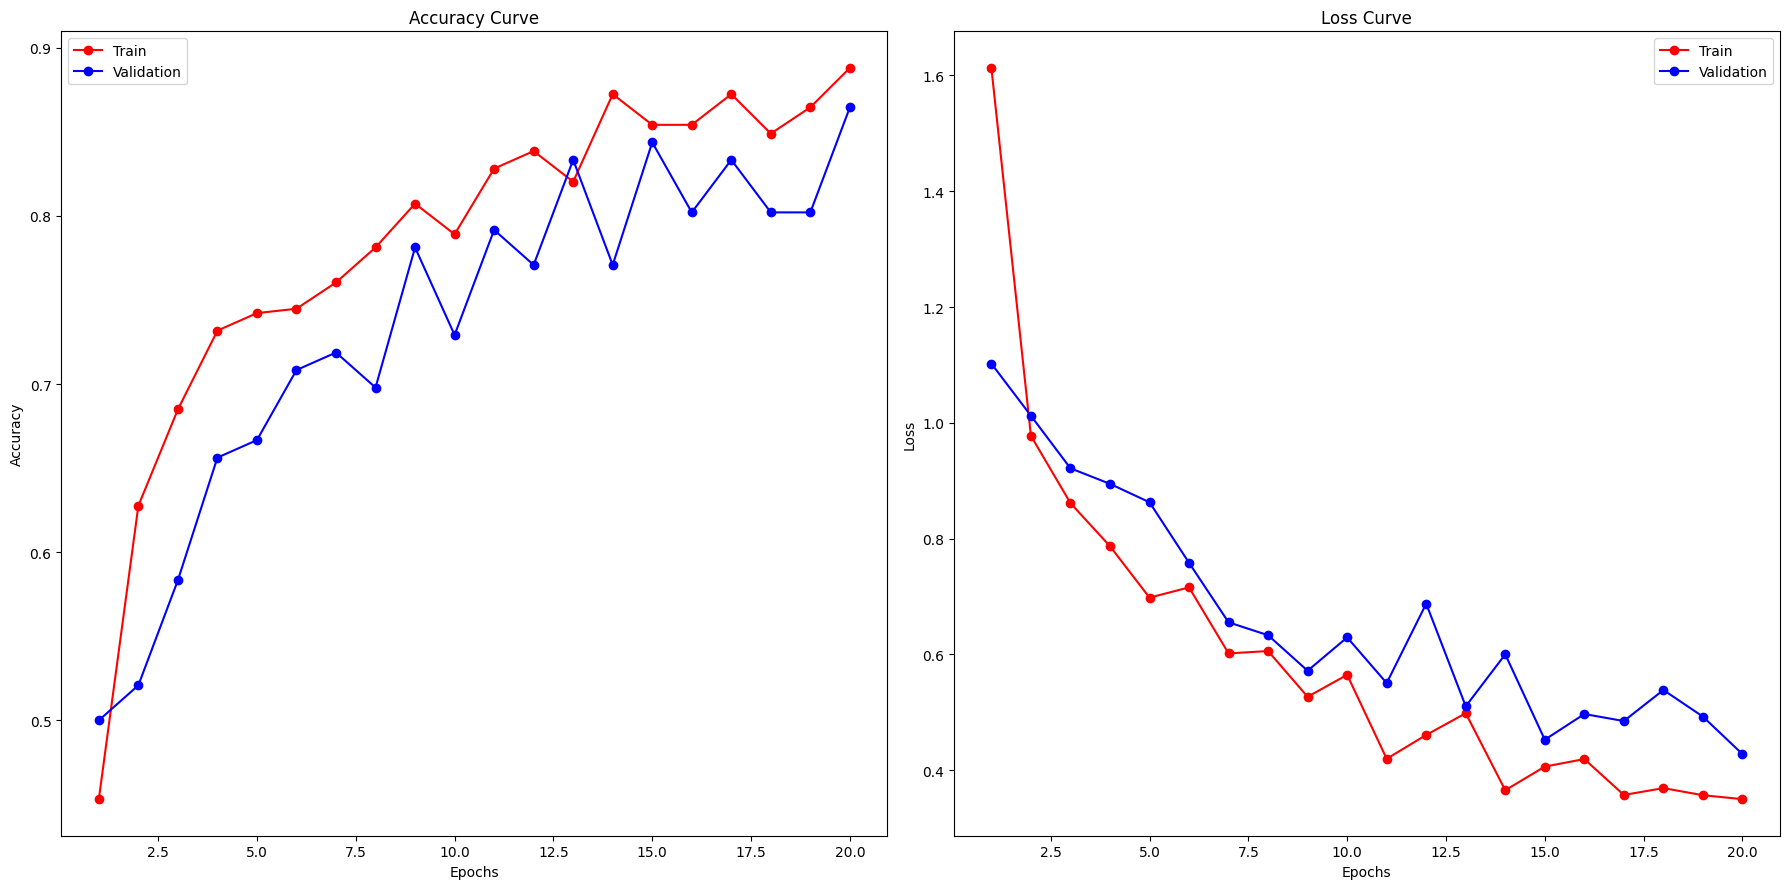

In [325]:
figure, axes = plt.subplots(1, 2, figsize=(18, 9))
epochs = range(1, len(history.history['accuracy']) + 1)

# Plotting Accuracy
axes[0].plot(epochs, history.history['accuracy'], 'ro-', label='Train')
axes[0].plot(epochs, history.history['val_accuracy'], 'bo-', label='Validation')
axes[0].set_xlabel('Epochs'), axes[0].set_ylabel('Accuracy'), axes[0].set_title('Accuracy Curve')
axes[0].legend()

# Plotting Loss
axes[1].plot(epochs, history.history['loss'], 'ro-', label='Train')
axes[1].plot(epochs, history.history['val_loss'], 'bo-', label='Validation')
axes[1].set_xlabel('Epochs'), axes[1].set_ylabel('Loss'), axes[1].set_title('Loss Curve')
axes[1].legend()

# Adjust layout and show the plot
figure.tight_layout()
plt.show()

##### **4.2. Plot Confusion Matrix**

In [323]:
test_data_generator = ImageDataGenerator(rescale=1./255)

# Generator for test data
test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generator for provided data
test_generator2 = test_data_generator.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

saved_model = tf.keras.models.load_model('model_ckpt.model.keras')

# Get true labels
true_labels = test_generator.classes

# Predict labels
saved_predictions = saved_model.predict(test_generator, verbose=1)
saved_predictions2 = saved_model.predict(test_generator2, verbose=1)

Found 480 images belonging to 4 classes.
Found 480 images belonging to 4 classes.
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step


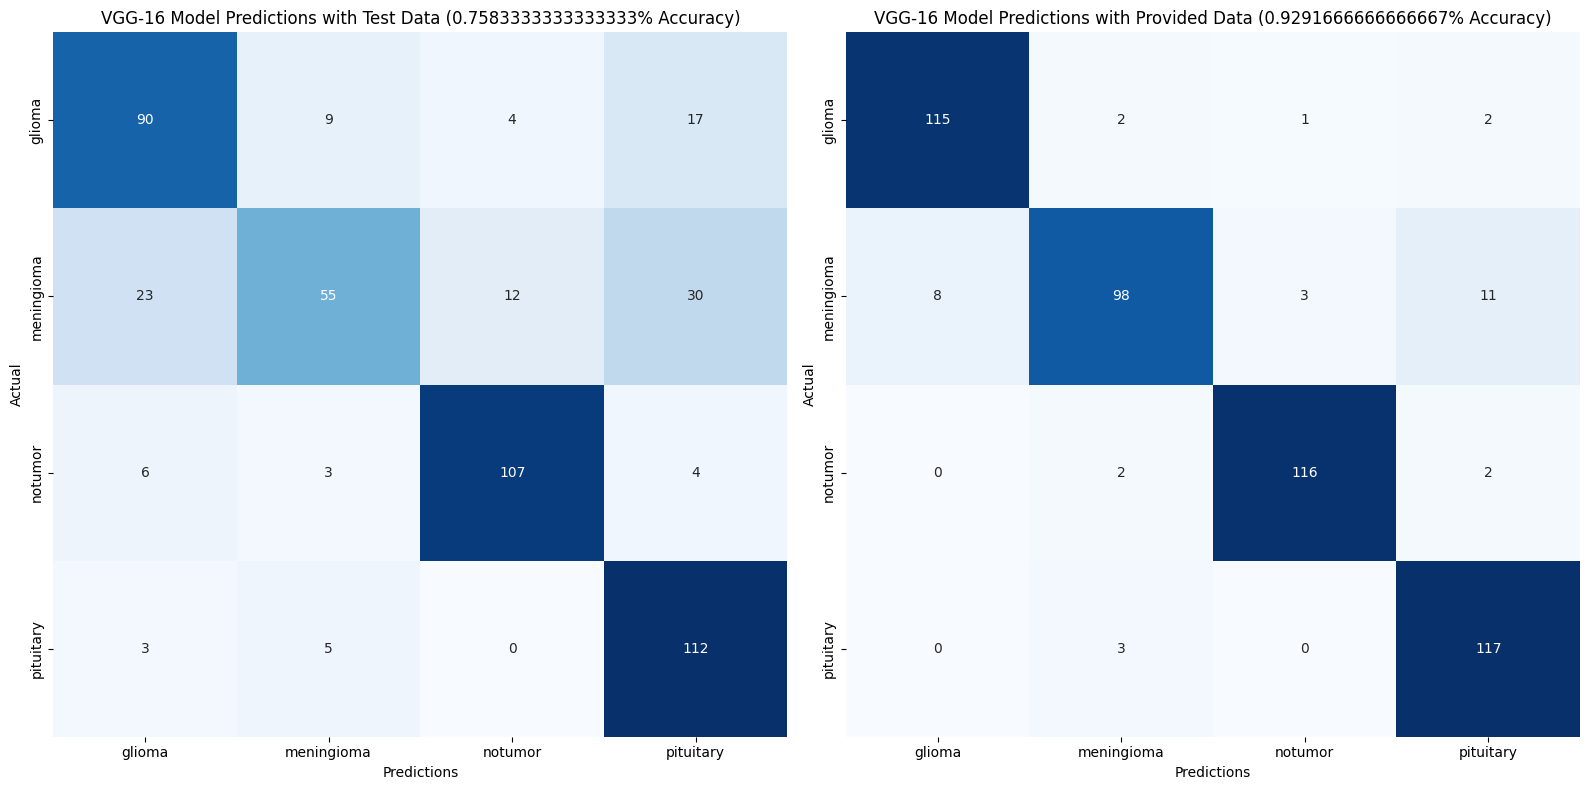


Classification Report:
              precision    recall  f1-score   support

      glioma       0.74      0.75      0.74       120
  meningioma       0.76      0.46      0.57       120
     notumor       0.87      0.89      0.88       120
   pituitary       0.69      0.93      0.79       120

    accuracy                           0.76       480
   macro avg       0.76      0.76      0.75       480
weighted avg       0.76      0.76      0.75       480



In [330]:
predicted_labels = np.argmax(saved_predictions, axis=1)
predicted_labels2 = np.argmax(saved_predictions2, axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)
accuracy2 = accuracy_score(true_labels, predicted_labels2)

# Define a function to plot confusion matrix
def plot_confusion_matrix(ax, true_labels, predicted_labels, title, labels=None):
    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Display confusion matrix as a heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    # Set labels for x and y axis
    if labels is not None:
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('Actual')
    ax.set_title(title)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot confusion matrix for test data and provided data
plot_confusion_matrix(axs[0], true_labels, predicted_labels, f'VGG-16 Model Predictions with Test Data ({accuracy:.4f}% Accuracy)', labels=test_generator.class_indices)
plot_confusion_matrix(axs[1], true_labels, predicted_labels2, f'VGG-16 Model Predictions with Provided Data ({accuracy2:.4f}% Accuracy)', labels=test_generator2.class_indices)

plt.tight_layout()
plt.show()

print('\nClassification Report:')
print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))